In [692]:
import pandas as pd
import numpy as np

# Plotting tools
import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud as wc
from wordcloud import STOPWORDS
import scikitplot.metrics as skplt
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Text Cleaning and Preprocessing
from collections import Counter
from scipy.stats import expon
import unicodedata
import re
import string
from textblob import TextBlob
import spacy

import nltk
from nltk.corpus import stopwords

# sklearn
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging (for gensim)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import time
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#export model to a file
import joblib

## Flair Labels

In [693]:
flairs = ['Politics', 'Photography', 'Policy/Economy', 'AskIndia', 'Sports', 'Non-Political', 'Scheduled', 
          'Science/Technology', 'Food', 'Business/Finance', 'Coronavirus', 'AMA', '[R]eddiquette']

## Reading the Data

In [694]:
flair_data = pd.read_csv("data_200.csv")

In [695]:
flair_data.sample(5)

,body,comment,created,id,title,url,label
1142,hi everyone planning buy apartment hafeezpet t...,said parents india assuming abroad actually pa...,1.524185e+09,8dg2ih,buying apartment hyderabad,https://www.reddit.com/r/india/comments/8dg2ih...,AskIndia
2194,hi pilots especially anyone airlines like klm ...,indian origin pilot ama couple years ago pleas...,1.529107e+09,8rc0rn,commercial pilot questions,https://www.reddit.com/r/india/comments/8rc0rn...,AMA
2430,The home ministry on Sunday has asked State go...,> In a letter to chief secretaries of all Stat...,1.586773e+09,g0g9kn,MHA asks states to facilitate movement of truc...,https://www.reddit.com/r/india/comments/g0g9kn...,Coronavirus
877,NaN,posted start day 3s play aus 1st innings total...,1.546036e+09,aaaozr,people would laughed someone 90s predicted one...,https://i.redd.it/5njv25kp21721.jpg,Sports
1063,hey guys 23 year old living currently mumbai i...,u perform u attracted particular client usuall...,1.542216e+09,9wyjtx,year quarter since became indian gigolo ask an...,https://www.reddit.com/r/india/comments/9wyjtx...,AMA


## Histogram for Sample Count
To confirm that the data scraped is balanced and unbiased per flair

In [696]:
flair_data['label'].value_counts()

Coronavirus           200
Food                  200
Scheduled             200
Business/Finance      200
[R]eddiquette         200
Non-Political         200
Science/Technology    200
Photography           200
Politics              200
Sports                200
AMA                   200
Policy/Economy        200
AskIndia              200
Name: label, dtype: int64

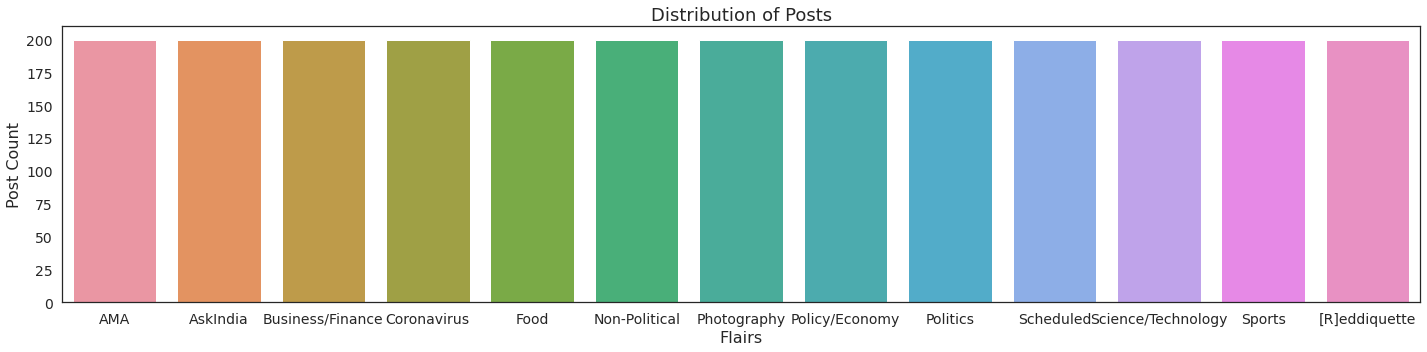

In [697]:
def barplot(df, x, y, title, label, ylabel, dim, orient = "v", ci = False, hue = None):
    
    plt.figure(figsize = dim, facecolor = "white")
    sns.barplot(x = x, y = y, data = df, orient = orient, ci = ci, hue = hue)
    plt.title(f"{title}", size = 18)
    plt.xlabel(f"{label}", size = 16)
    plt.ylabel(f"{ylabel}", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();
    

df = (flair_data.set_index(['id', 'label']).count(level='label'))

barplot(df = df,
        x = df.index,
        y = "url",
        title = "Distribution of Posts",
        label = "Flairs",
        ylabel = "Post Count",
        dim = (20,5))

**Observation:** My intuition was correct and the data is balanced (sampled 200 each flairwise)

### Checking for Null Values

In [698]:
print("Null value counts for each Feature: ")
flair_data.isna().sum()

Null value counts for each Feature: 


body       1469
comment     151
created       0
id            0
title         0
url           0
label         0
dtype: int64

**Observtion:** As I suspected, some posts are less active & hence don't gather much user attention and some submissions that contain multimedia links (i.reddit, v.reddit, imgur, Youtube, Twitter, etc..) lack a selftext body.

## Combining Features
Creating a new feature 'combined' which consists of the submission url, title, selftext and top comments. Taking into account the size of the dataset scraped and the presence of null values within the body and top comments, dropping null-valued tuples will result in data loss, class imbalance and therefore, poor accuracy of the classifier. Moreover, the features combined are a subset of 'combined' which implies we get the best of the other features present.

In [699]:
# combining features
flair_data["combined"] = flair_data["url"].map(str) + " " + flair_data["title"].map(str) + " " + flair_data["body"].map(str) + " " + flair_data["comment"].map(str)
flair_data.head(1)

,body,comment,created,id,title,url,label,combined
0,reposting lack activity r askindiahello last y...,dear policy holder dhavalcoholic request help ...,1.386254e+09,1s57oi,need feedback insurance policy took xpost aski...,https://www.reddit.com/r/india/comments/1s57oi...,AskIndia,https://www.reddit.com/r/india/comments/1s57oi...


## Data Cleaning
Cleaning and Preprocessing the combined text as usual; I detected a presence of urls (http...), subreddits (r/...), and users (u/...) referenced within the comments and self text along with special formatting characters that resembled markdown (>, #, \[, \], etc), zero-width spaces (&#x200B), ASCII spaces (\n, \t, etc) and a few HTML tags (&nbsp). Moreover, I extended the list of stopwords based on observaions that occured in each flair from the [word cloud and most frequently occuring words](http://34.73.225.220:4444/notebooks/Part%202%20-%20EDA%2C%20Data%20Preprocessing%20and%20Feature%20Engineering.ipynb#Frequently-occuring-words-(per-Flair)).

In [700]:
#cleaning combined data
stop_words = stopwords.words('english') # stopwords
# extended = ['nan', 'https','http', 'redd','com', 'www', 'x200b', 'nbsp', 'like', 'dont', 'people', 'india', 'indian', 'time', 'good', 'want', 'think', 'know', 'need', 'make', 'thing', 'year', 'day', "0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "A", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "after", "afterwards", "ag", "again", "against", "ah", "ain", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appreciate", "approximately", "ar", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "B", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "been", "before", "beforehand", "beginnings", "behind", "below", "beside", "besides", "best", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "C", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "ci", "cit", "cj", "cl", "clearly", "cm", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "could", "couldn", "couldnt", "course", "cp", "cq", "cr", "cry", "cs", "ct", "cu", "cv", "cx", "cy", "cz", "d", "D", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "dj", "dk", "dl", "do", "does", "doesn", "doing", "don", "done", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "E", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "F", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "G", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "H", "h2", "h3", "had", "hadn", "happens", "hardly", "has", "hasn", "hasnt", "have", "haven", "having", "he", "hed", "hello", "help", "hence", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hes", "hh", "hi", "hid", "hither", "hj", "ho", "hopefully", "how", "howbeit", "however", "hr", "hs", "http", "hu", "hundred", "hy", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "im", "immediately", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "inward", "io", "ip", "iq", "ir", "is", "isn", "it", "itd", "its", "iv", "ix", "iy", "iz", "j", "J", "jj", "jr", "js", "jt", "ju", "just", "k", "K", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "ko", "l", "L", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "M", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "my", "n", "N", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "neither", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "O", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "otherwise", "ou", "ought", "our", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "P", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "pp", "pq", "pr", "predominantly", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "Q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "R", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "S", "s2", "sa", "said", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "seem", "seemed", "seeming", "seems", "seen", "sent", "seven", "several", "sf", "shall", "shan", "shed", "shes", "show", "showed", "shown", "showns", "shows", "si", "side", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somehow", "somethan", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "sz", "t", "T", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "thats", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "thereof", "therere", "theres", "thereto", "thereupon", "these", "they", "theyd", "theyre", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "U", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "used", "useful", "usefully", "usefulness", "using", "usually", "ut", "v", "V", "va", "various", "vd", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "W", "wa", "was", "wasn", "wasnt", "way", "we", "wed", "welcome", "well", "well-b", "went", "were", "weren", "werent", "what", "whatever", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "whom", "whomever", "whos", "whose", "why", "wi", "widely", "with", "within", "without", "wo", "won", "wonder", "wont", "would", "wouldn", "wouldnt", "www", "x", "X", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "Y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "your", "youre", "yours", "yr", "ys", "yt", "z", "Z", "zero", "zi", "zz"]
extended =  ['nan', 'https','http', 'redd','com', 'reddit', 'wwwredditcom', 'get', 'imgurcom', 'iimgurcom', 'www', 'x200b', 'nbsp', 'like', 'dont', 'people', 'india', 'indian', 'time', 'good', 'want', 'think', 'know', 'need', 'make', 'thing', 'year', 'day', 'reddit', 'comments', 'comment']
stop_words.extend(extended)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_text(sentence):
    if type(sentence) == type('a'):
        sentence = unicodeToAscii(sentence.lower().strip())
        sentence = re.sub(r"([.!?])", r" \1", sentence)
        sentence = re.sub(r'[/(){}\[\]\|@,;:.]', r' ', str(sentence))
        sentence = re.sub(r"[^a-z]+", r" ", sentence)
        sentence = ' '.join(word for word in sentence.split() if word not in stop_words and len(word)>2)
        return sentence

In [701]:
flair_data["combined_cleaned"]  = flair_data["combined"].apply(lambda x: clean_text(x))

## Text Normalization
Even though the goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form, I chose lemmatization because processing time wasn't a big issue and I wanted a better normaliztion. Moreover, it's easier to find the occurrences of Part of Speech with spacy.

In [702]:
#POS Tagging (takes time to process)

total_tokens = []
freq = {}
for submission in flair_data['combined_cleaned']:
    doc = nlp(submission)
    tokens = []
    for word in doc:
        pos = word.pos_
        if (pos in freq): 
            freq[pos] += 1
        else: 
            freq[pos] = 1
        tokens.append(pos)
        
    total_tokens.append(tokens)
    
pos_df = pd.DataFrame({'POS': list(freq.keys()), 'Frequency':list(freq.values())})

### Part-of-Speech Distribution

      POS  Frequency
0    VERB     139202
1    NOUN     228608
2   PROPN     126325
3     ADJ      78591
4     ADV      36517
5     ADP       5929
6   CCONJ        689
7    INTJ       2481
8   SCONJ       2786
9    PRON       7054
10      X       1066
11    AUX       1645
12   PART       3359
13    NUM       5288
14    DET       2763
15  PUNCT         25
16    SYM          7

Part-of-speech tagging counts for combined corpus


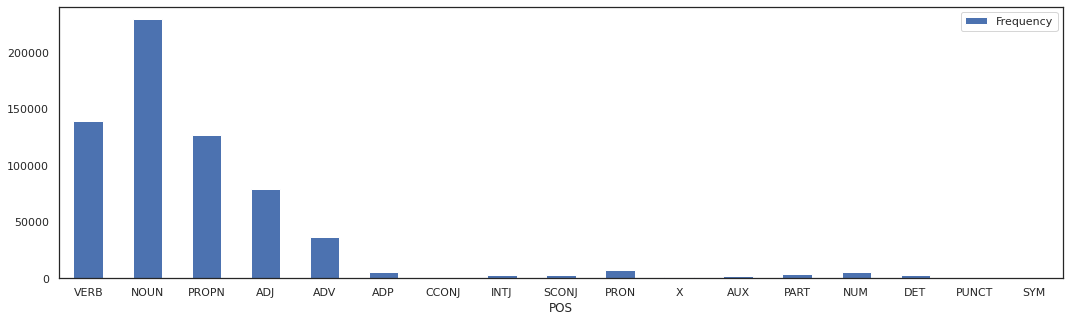

In [703]:
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### Text Lemmatization
Hence I proceeded to exclude the POS components I assumed would affect my classification, for eg. the base32 encoded id of urls left over after previous cleaning and substitutions ('3g1jfi' of https://www.reddit.com/r/funny/comments/3g1jfi/buttons/), Cardinal Digits, Pronouns, etc.

In [1]:
# Takes time to process
nlp = spacy.load('en_core_web_sm')
allowed_postags=['PROPN', 'VERB', 'NOUN', 'ADV', 'ADJ'] # According to occurence in POS Tagging 

lemmatized_submissions = []
for submission in flair_data['combined_cleaned']:
    doc = nlp(submission)
    submission = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    lemmatized_submissions.append(" ".join(submission))
    
flair_data['combined_lemmatized'] = lemmatized_submissions

NameError: name 'spacy' is not defined

In [ ]:
flair_data['combined_lemmatized']

## Frequently occuring words (per Flair)
I analyzed these statistics in hopes of finding redundant stopwords that occur (in every flair) frequently.

In [ ]:
def plot_most_frequent_words(df, flair):
    cnt = 0
    fig = plt.figure(figsize   = (24,20), facecolor = "white")   
    cnt += 1
    ax = fig.add_subplot(2, 2, cnt)

    sns.barplot(x = 0, y = df.index, data = df, palette = "deep")

    # Configurong Graph parameters
    plt.title(f"Most Common Words from {flair} are", size = 20)
    plt.xlabel("Frequency", size = 18)
    plt.ylabel("Word", size = 18)
    plt.xticks(size = 16)
    plt.yticks(size = 17)

In [ ]:
sns.set(style="white", palette = "deep")
cvec = CountVectorizer()

for flair in flairs:
    subset = flair_data[flair_data["label"] == flair]
    vecs = cvec.fit_transform(subset["combined_lemmatized"])
    vectorized_df = pd.DataFrame(vecs.toarray(), columns = cvec.get_feature_names())

    # Getting the 20 most frequent words from each
    frequent = pd.DataFrame(vectorized_df.sum().sort_values(ascending = False).head(20))
    
    plot_most_frequent_words(df = frequent, flair = flair)

In [ ]:
# Word Cloud per Flair

for flair in flairs:
    words = ''
    stopwords = set(STOPWORDS)

    for val in flair_data[flair_data["label"]==flair]['combined_lemmatized']: 
        tokens = str(val).split() 
        words += " ".join(tokens)+" "

    wordcloud = wc(width = 800, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(words) 

    # plotting the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    print(f"{flair}:")
    plt.show()
    print("\n\n\n")

**Observation:** I conclude that _['nan', 'https', 'http', 'redd','com', 'reddit', 'wwwredditcom', 'get', 'imgurcom', 'iimgurcom', 'www', 'x200b', 'nbsp', 'like', 'dont', 'people', 'india', 'indian', 'time', 'good', 'want', 'think', 'know', 'need', 'make', 'thing', 'year', 'day', 'reddit', 'comments', 'comment']_ are present frequently in every flair. Moreover, these plots present an accurate picture of the distribution and type of words in these flairs themselves


## Text and Word Length Statistics

In [ ]:
lengths = [len(text) for text in flair_data["combined_lemmatized"]] # text lengths

plt.figure(figsize = (16,6), facecolor = "white")
sns.distplot(lengths, kde = False, bins = 100, color = "black")
plt.axvline(np.mean(lengths), color = "red") # the mean length
plt.title("Distribution Of Text Length", size = 18)
plt.xlabel("Words", size = 4)
plt.ylabel("Frequency", size = 16)
plt.xticks(np.arange(0,2895,100), size = 14)
plt.yticks(size = 14);

## Topic Modelling
Finding correlation and codependencies between words and topics generated. 

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(sent_to_words(flair_data['combined_lemmatized']))

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_words_bigrams = make_bigrams(data_words)

In [ ]:
id2word = corpora.Dictionary(data_words_bigrams) # Create Dictionary
texts = data_words_bigrams # Create Corpus
corpus = [id2word.doc2bow(text) for text in texts] # Term Document Frequency

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pprint(optimal_model.print_topics(num_words=10))

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='mmds')
vis

**Observation:** As can be observed (from previous plots and topic modelling), some of the topics generated actually resemble flairs accrately and they aren't mutually excusive. Hence I conclude the same for the flair features generated.

### Feature Extraction

In [ ]:
# saving the finalized data
flair_data.to_csv('final_data.csv', index=False)

In [ ]:
X_Train, X_Test, y_train, y_test = train_test_split(flair_data['combined_lemmatized'], flair_data['label'], random_state = 0, test_size = 0.3)

#### t-SNE

In [ ]:
def run_tsne(X_train_text_df,y_train,X_test_text_df,y_test,vec_columns_count):
    temp_data_train = pd.concat([X_train_text_df,y_train.reset_index(drop=True)], axis = 1)
    temp_data_test = pd.concat([X_test_text_df,y_test.reset_index(drop=True)], axis = 1)
    temp_data = pd.concat([temp_data_train,temp_data_test],axis = 0).reset_index(drop=True)
    
    time_start = time.time()
    algo = TSNE(n_components=2,random_state = 0,n_iter = 2000)
    tsne_data = algo.fit_transform(temp_data.iloc[:,:vec_columns_count])
    time_end = time.time()
    print('t-SNE Completed. Total time it took: {} seconds'.format(time_end-time_start))
    
    #plotting it
    tsne_data = np.vstack((tsne_data.T,temp_data.label)).T
    tsne_df = pd.DataFrame(data = tsne_data , columns=("Dim1","Dim2","label"))
    sns.FacetGrid(data = tsne_df , hue = 'label',size = 15).map(plt.scatter,"Dim1","Dim2").add_legend()
    plt.show()

##### Bag-Of-Words Vectorizer

In [ ]:
# BoW Vectorization

cv_comments = CountVectorizer(ngram_range=(1, 5), min_df=.1)

In [ ]:
X_train_comments = cv_comments.fit_transform(X_Train)
X_train_text_df = pd.DataFrame(X_train_comments.todense(), columns=[x+'_text' for x in cv_comments.get_feature_names()])
X_train_text_df.shape

In [ ]:
#saving bow model to a pickle file
filename = 'bow_vec.pkl'
joblib.dump(cv_comments, filename)

In [ ]:
X_test_comments = cv_comments.transform(X_Test)
X_test_text_df = pd.DataFrame(X_test_comments.todense(), columns=[x+'_text' for x in cv_comments.get_feature_names()])
X_test_text_df.shape

In [ ]:
cv_comments.get_feature_names()

In [ ]:
run_tsne(X_train_text_df,y_train,X_test_text_df,y_test, X_train_text_df.shape[1])

**Observation:** Some label clusters are disinctly separable and I conclude those classes to perform better at Classification (to the extent of false positives due to overfitting)

##### TF IDF Vectorizer

In [ ]:
# Applying TFIDF
tfidf_comments = TfidfVectorizer(ngram_range=(1, 5), min_df=.1)

In [ ]:
X_train_tfidf_comments = tfidf_comments.fit_transform(X_Train)
X_train_tfidf_text_df = pd.DataFrame(X_train_tfidf_comments.todense(), columns=[x+'_text' for x in tfidf_comments.get_feature_names()])
X_train_tfidf_text_df.shape

In [ ]:
X_test_tfidf_comments = tfidf_comments.transform(X_Test)
X_test_tfidf_text_df = pd.DataFrame(X_test_tfidf_comments.todense(), columns=[x+'_text' for x in tfidf_comments.get_feature_names()])
X_test_tfidf_text_df.shape

In [ ]:
#saving bow model to a pickle file
filename = 'tfidf_vec.pkl'
joblib.dump(tfidf_comments, filename)

In [ ]:
tfidf_comments.get_feature_names()

In [ ]:
run_tsne(X_train_tfidf_text_df,y_train,X_test_tfidf_text_df,y_test, X_train_text_df.shape[1])

**Observation:** Label clusters are better separable and uniquely comprehendable, I suspect TF-IDF will perform better than BOW Vectorizer

##### Word2Vec Vectorizer

In [ ]:
X_tr, X_cv, y_tr, y_cv = train_test_split(flair_data['combined_cleaned'], flair_data['label'], test_size=0.3)

In [ ]:
list_of_sent=[]
for sent in X_tr.values:
    filtered_sentence=[]
    for w in sent.split():
        if(w.isalpha()):    
            filtered_sentence.append(w.lower())
        else:
            continue 
    list_of_sent.append(filtered_sentence)

In [ ]:
# w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [ ]:
# words = list(w2v_model.wv.vocab)
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

In [ ]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [ ]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
# train, test = train_test_split(df, test_size=0.3, random_state = 42)
train, test = train_test_split(flair_data[['combined_cleaned','label']], test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['combined_cleaned']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['combined_cleaned']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [ ]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test['label'], y_pred,target_names=flairs))
print(skplt.plot_confusion_matrix(y_test, y_pred))

**Observation:** Average Word2Vec (with pre-loaded vectors) Vectorized data seems to perform worse, and possibly overfits by a large margin and hence I won't be using it. (similar models were run for prevous vectorizers and the seemingly performed better and hence were pickled)